In [1]:
import glob

import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def get_latest_output_dir(reward, strategy, policy_cls, index=-1):
    output_dir = sorted(glob.glob(f"../records/{reward}/{strategy}/{policy_cls}/*"))[index]
    return output_dir


def plot_metrics(train_reward, valid_reward, strategy, policy_cls, scale=1, ann_scaler=252, norm_steps_per_episode=False, val_every_n_iters=1, index=-1):
    
    output_dir = get_latest_output_dir(train_reward, strategy, policy_cls, index)
    
    try:
        df_baseline_train = pd.read_csv(f"{output_dir}/baseline_train/result.csv")
        df_baseline_valid = pd.read_csv(f"{output_dir}/baseline_valid/result.csv")
    except:
        df_baseline_train = pd.read_csv(f"{output_dir}/baseline/result.csv")
        df_baseline_valid = pd.read_csv(f"{output_dir}/baseline/result.csv")
    df_training = pd.read_csv(f"{output_dir}/metrics/train_result.csv", index_col=0)
    df_policy_train = pd.read_csv(f"{output_dir}/metrics/validation_train_result.csv", index_col=0)
    df_policy_valid = pd.read_csv(f"{output_dir}/metrics/validation_result.csv", index_col=0)
    df_baseline_train = df_baseline_train.loc[df_baseline_train.index.repeat(len(df_training))].reset_index(drop=True)
    df_baseline_valid = df_baseline_valid.loc[df_baseline_valid.index.repeat(len(df_training))].reset_index(drop=True)
    
    df_policy_train.index = pd.Index((np.arange(len(df_policy_train)) + 1)*val_every_n_iters - 1)
    df_policy_valid.index = pd.Index((np.arange(len(df_policy_valid)) + 1)*val_every_n_iters - 1)

    df_training["reward"] = df_training["reward"] / scale * ann_scaler
    
    if norm_steps_per_episode:
        df_training["reward"] = df_training["reward"] / df_training["steps_per_episode"]
    
    df = pd.DataFrame({
        "baseline_train": df_baseline_train["reward"],
        "baseline_valid": df_baseline_valid["reward"],
        "training": df_training["reward"],
        "policy_train": df_policy_train["val_train/reward"],
        "policy_valid": df_policy_valid["val/reward"]
    })
    
    print(f"Loaded metrics from: {output_dir}")
    print(df.dropna())
    best = df.dropna().sort_values("policy_valid", ascending=True).iloc[-1].to_dict()
    corr_train = scipy.stats.spearmanr(df.dropna()["training"], df.dropna()["policy_train"]).correlation
    corr_valid = scipy.stats.spearmanr(df.dropna()["training"], df.dropna()["policy_valid"]).correlation
    
    plt.figure(figsize=(10,6))
    for col in df.columns:
        plot_data = df[col].dropna()
        plt.plot(plot_data.index.values, plot_data.values, label=col)
    plt.legend([
        f"baseline_train ({best['baseline_train']:.5f})", 
        f"baseline_valid ({best['baseline_valid']:.5f})", 
        f"training ({best['training']:.5f}, mean={df['training'].mean():.5f}, std={df['training'].std():.5f})", 
        f"policy_train ({best['policy_train']:.5f}, mean={df['policy_train'].mean():.5f}, std={df['policy_train'].std():.5f}, corr={corr_train:.5f})", 
        f"policy_valid ({best['policy_valid']:.5f}, mean={df['policy_valid'].mean():.5f}, std={df['policy_valid'].std():.5f}, corr={corr_valid:.5f})"
    ])
    plt.title(f"{strategy} ({policy_cls})")
    plt.xlabel("Episode")
    plt.ylabel(train_reward)

Loaded metrics from: ../records/ExecutionMeanVarianceReward/TopkDropoutDiscreteRerankDynamicParamStrategy/TopkMetaPPO/2023_04_05_22_23
   baseline_train  baseline_valid  training  policy_train  policy_valid
0        0.090974        1.628009 -0.467673     -1.173227      0.518272


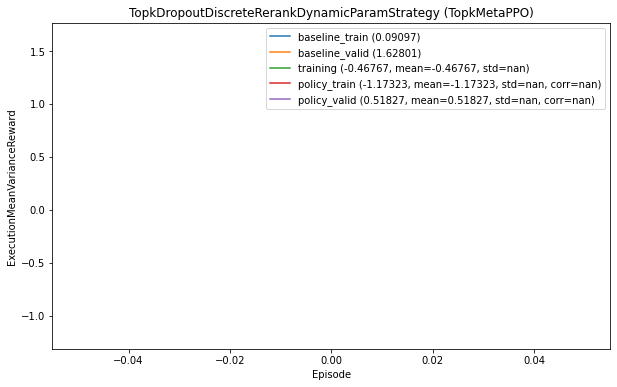

In [3]:
plot_metrics(
    train_reward="ExecutionMeanVarianceReward",
    valid_reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutDiscreteRerankDynamicParamStrategy",
    policy_cls="TopkMetaPPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False,
    val_every_n_iters=1,
    index=-1
)